### This notebook attempts to capture the Madden-Julian Oscillation pattern by looking at some datasets of Outgoing Longwave Radiation. The method used is K-means clustering, which as you will see may not be very well-suited for finding this pattern. The [Madden-Julian Oscillation](https://en.wikipedia.org/wiki/Madden–Julian_oscillation) is an importnat mode of climate variability in the tropics associated with changes in rainfall. The data used for this can be found at [this NOAA page](https://psl.noaa.gov/data/gridded/data.interp_OLR.html). I used the daily mean.

### Currently it looks like the program is not working very well. Comparison with other MJO maps online suggests that I might be seeing some basically correct patterns, but it is very hard to decide which pattern corresponds to which phase of the MJO.

### For a better notebook that uses all of the data here rather than just the first 90 days, see the [other notebook].

In [ ]:
## Importing modules:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sklearn.cluster
import scipy.cluster
import sklearn.decomposition
from sklearn.preprocessing import StandardScaler

In [166]:
ds = xr.open_dataset('/Users/bennysmith/Documents/DATA 1150/Project datasets/olr.day.mean.nc') # Opening the dataset (I downloadedit to my laptop)

### Below I simply map an average of the OLR data across time for the tropics:

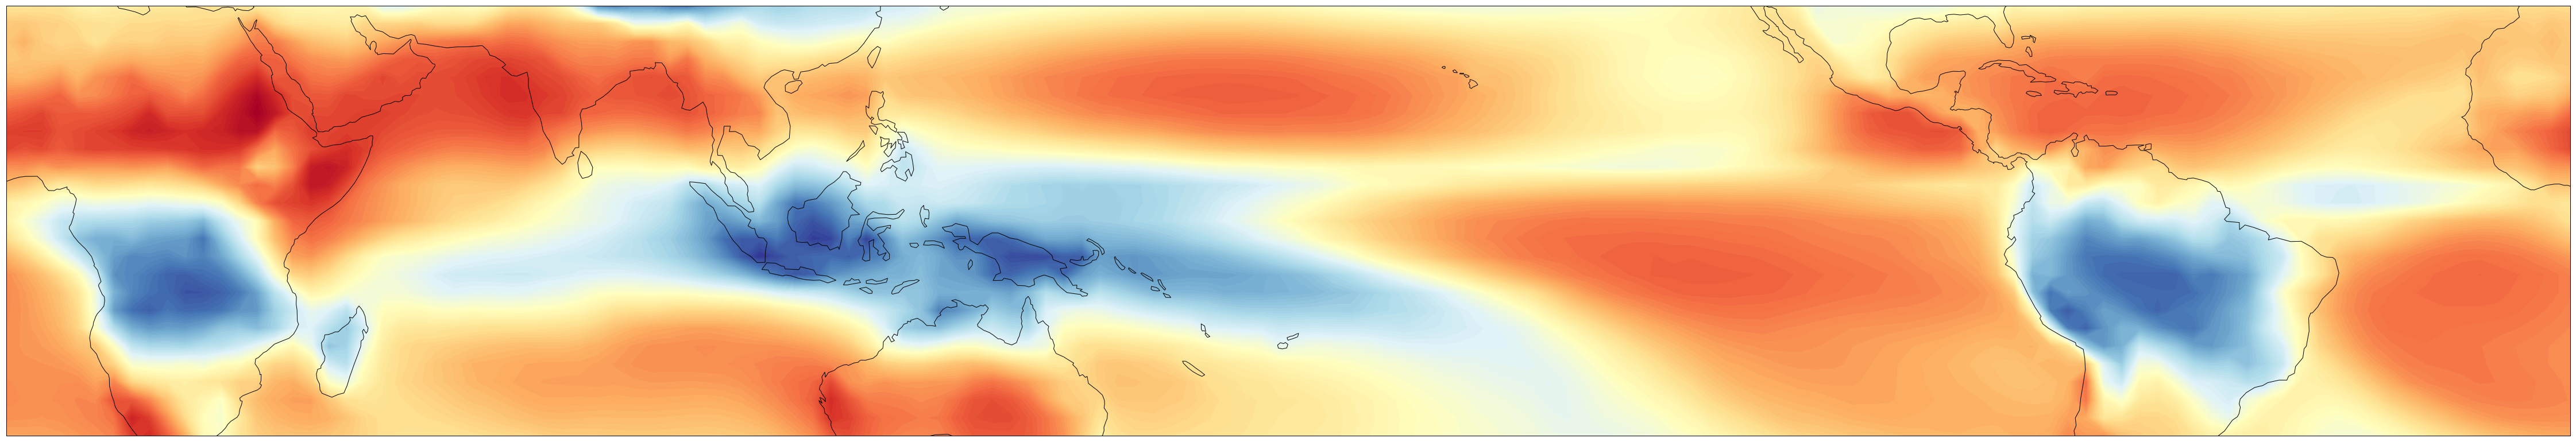

In [167]:
## I want to only select latitudes within 30 degrees of the equator:
lower_lat_index = list(ds.lat.values).index(30)
upper_lat_index = list(ds.lat.values).index(-30)+1

# lower_lon_index = list(ds.lon.values).index(20)
# upper_lon_index = list(ds.lon.values).index(240)+1

olr = ds.olr.isel(lat=slice(lower_lat_index, upper_lat_index)) # Choosing latitudes 20-80N
# olr=olr.isel(time=slice(0, 100))
olr = olr.interpolate_na(dim='time', method='linear') # There are a few missing values, which cause problems later in the program if I don't interpolate their values here.
# olr = olr.isel(lon=slice(lower_lon_index, upper_lon_index))

lat = ds.lat.isel(lat=slice(lower_lat_index,upper_lat_index)) # Defining a latitude variable
# lon = ds.lon.isel(lon=slice(lower_lon_index,upper_lon_index)) # Defining a latitude variable
lon = ds.lon

## I'm just looking at the DJF season:
def is_djf(month): # source: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months
  return (month>=12) | ((month>=1) & (month<=2)) # The | symbol is an OR operator
olr = olr.sel(time=is_djf(olr['time.month']))


olrvals = olr.values # Converting to a numpy array
olrmean = np.nanmean(olrvals, axis=0) # Averaging across time (np.nanmean can handle NaN values)

# Making a contour plot:
mins = []
maxes = []
fig = plt.figure(figsize=(20*4,5*4))
for i in olrmean:
  mins.append(min(i))
  maxes.append(max(i))
levels = np.linspace(min(mins), max(maxes), 100)
ax = plt.axes(projection=ccrs.LambertCylindrical(central_longitude=180))
cs=ax.contourf(lon, lat, olrmean[:, :],levels,
              transform=ccrs.LambertCylindrical(),
              cmap=plt.cm.RdYlBu_r)
ax.coastlines()
# ax.set_extent([-160, 60, -15, 15], crs=ccrs.LambertCylindrical(central_longitude=180)) # longitude latitude extent



# ax.set_extent([lower_lon_index, upper_lon_index, lower_lat_index, upper_lat_index]) # longitude latitude extent
# plt.colorbar(cs, orientation='vertical') # color map
plt.show()

### Next I will do the actual machine learning. In the following cell I compute the anomalies of the data by subtracting the time-average from each value (since I only took values in the DJF season this should not be too impacted by seasonal variations). I then do K-means clustering using SKlearn.

In [168]:
olranomalies = olrvals - olrmean # Computing anomalies
olrvals = olranomalies
olrvals = olrvals[:90, :, :] # Choosing only the first 90 days. This is to avoid having to go through too much data (90 days will include at least 1, and up to 3, cycles of the MJO)
olrvals = olrvals.reshape(len(olrvals[:, 0, 0]), len(lat)*len(lon)) # Reshaping the OLR dataset so that latitude & longitude are a single dimension. This makes clustering simpler.
number_clusters = 3 # To start off, I will just do three clusters.
kmeans_model = sklearn.cluster.KMeans(n_clusters=number_clusters, random_state=10).fit(olrvals)
mjo_clusters = kmeans_model.fit_predict(olrvals)
all_clusters = {}
for i in range(number_clusters):
  cluster_indices = np.argwhere(mjo_clusters == i)[:,0] # For each cluster, I want a cluster_indices array that tells me which parts of the dataset are in the current cluster number being considered.
  cluster_composite = np.mean(olrvals[cluster_indices], axis=0).reshape(len(lat), len(lon)) # reshaping the data so that I have it as a spatial grid again
  all_clusters['cluster'+str(i+1)+'_composite'] = cluster_composite # Adding the reshaped data to a dictionary

### Next I map the clusters:

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


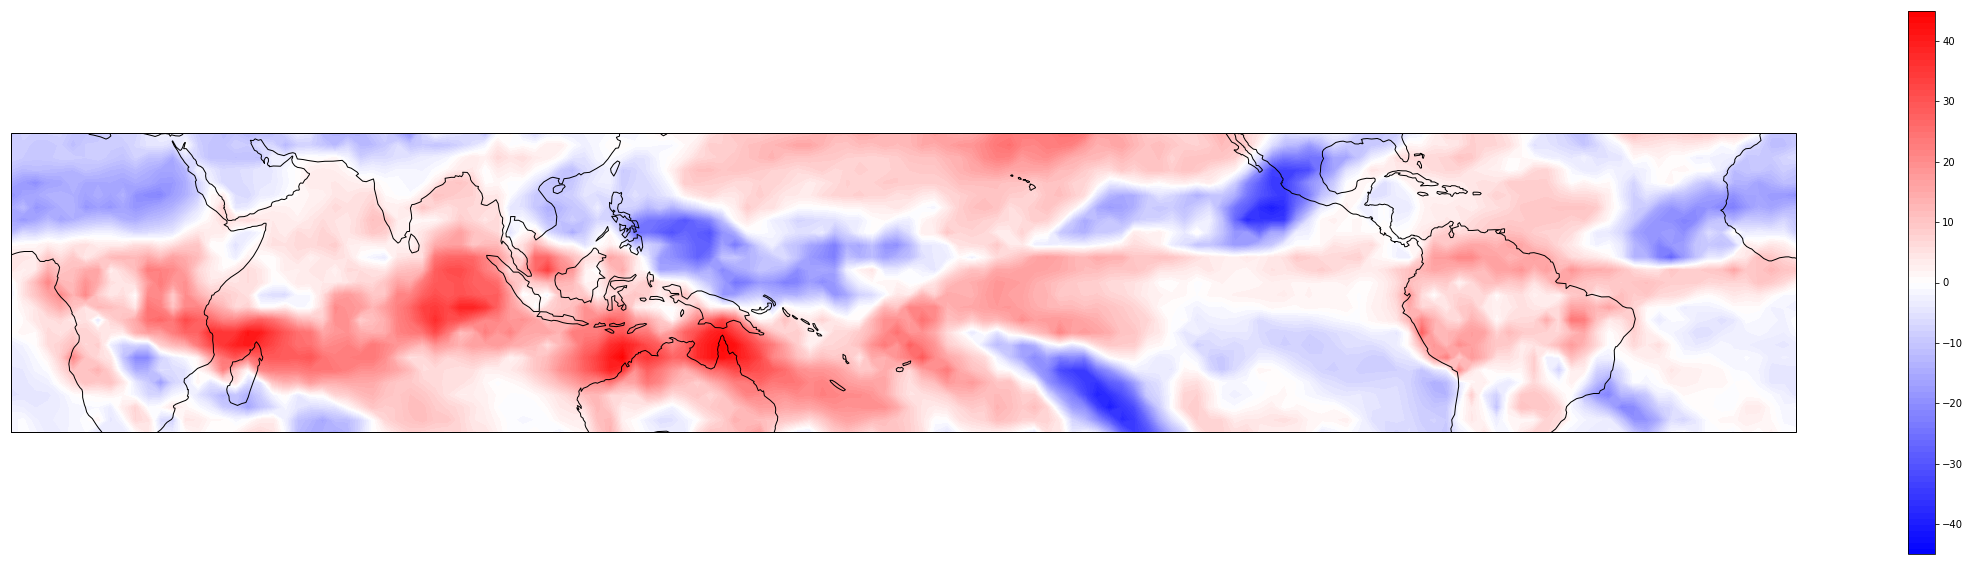

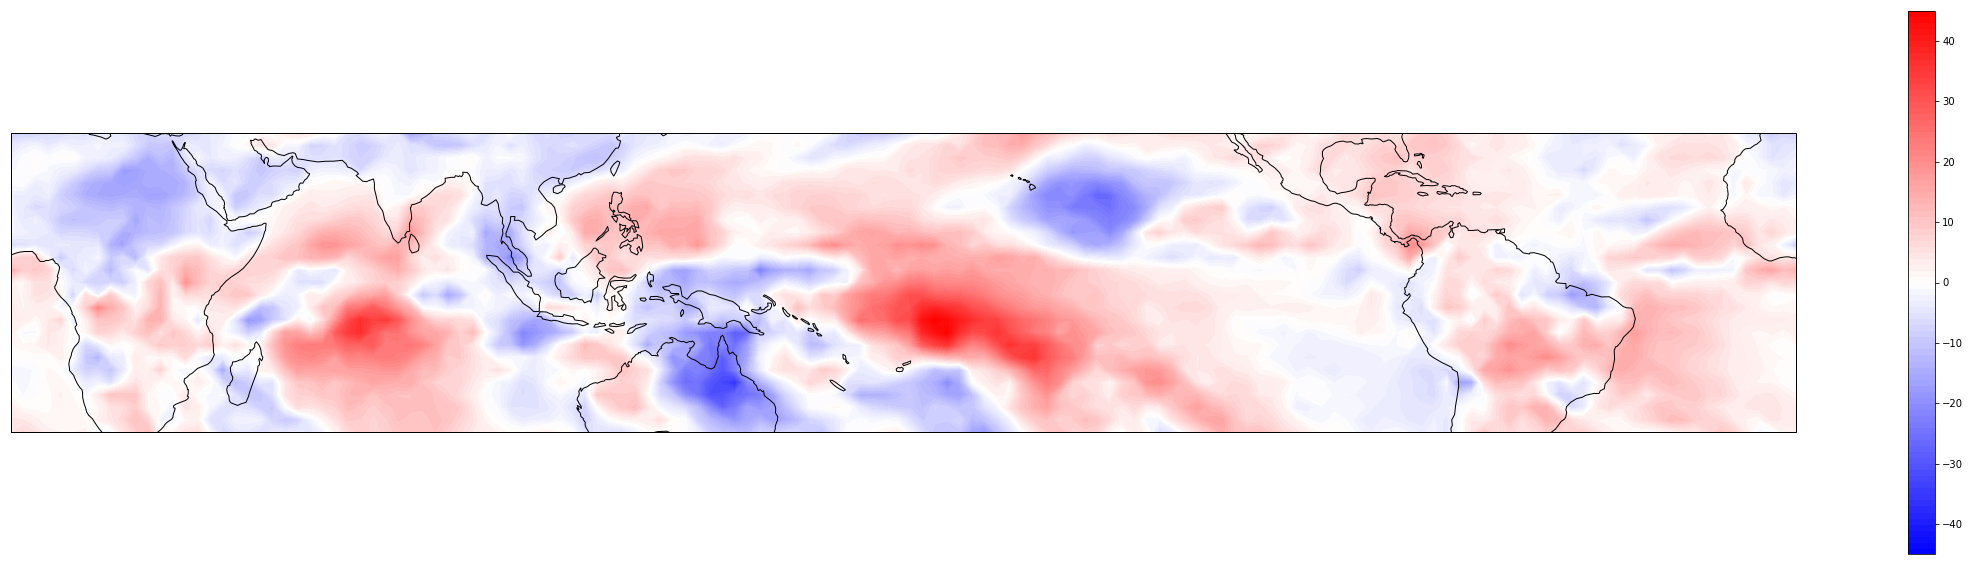

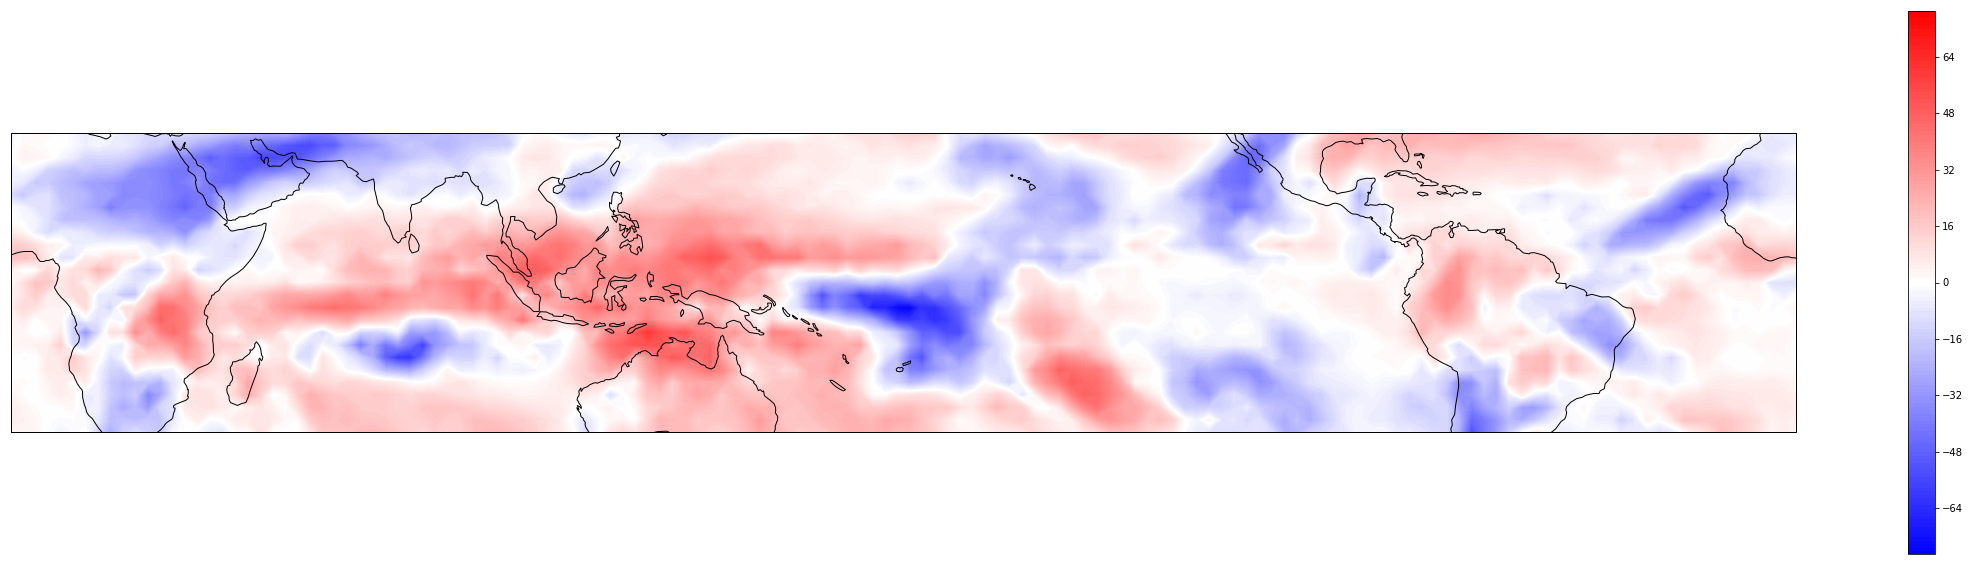

In [170]:
for i in range(number_clusters):
  mins = []
  maxes = []
  for j in all_clusters['cluster'+str(i+1)+'_composite']:
    mins.append(min(j))
    maxes.append(max(j))
  myrange = max(np.abs(min(mins)), np.abs(max(maxes)))
  levels = np.linspace(-np.ceil(myrange), np.ceil(myrange), 2*np.ceil(myrange)+1)
#   fig = plt.figure(figsize=(20*4,5*4))
  fig = plt.figure(figsize=(40,10))
  ax = plt.axes(projection=ccrs.LambertCylindrical(central_longitude=180))
  cs=ax.contourf(lon, lat, all_clusters['cluster'+str(i+1)+'_composite'][:, :],levels,
                transform=ccrs.LambertCylindrical(),
                cmap='bwr')
# cmap=plt.cm.RdYlBu_r
  ax.coastlines()
#   ax.set_extent([-90, 40, 20, 80]) # longitude latitude extent
  plt.colorbar(cs, orientation='vertical') # color map
  plt.show()

### This is similar code for mapping the clusters, just shown with the previous cells having been done with 4 clusters.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


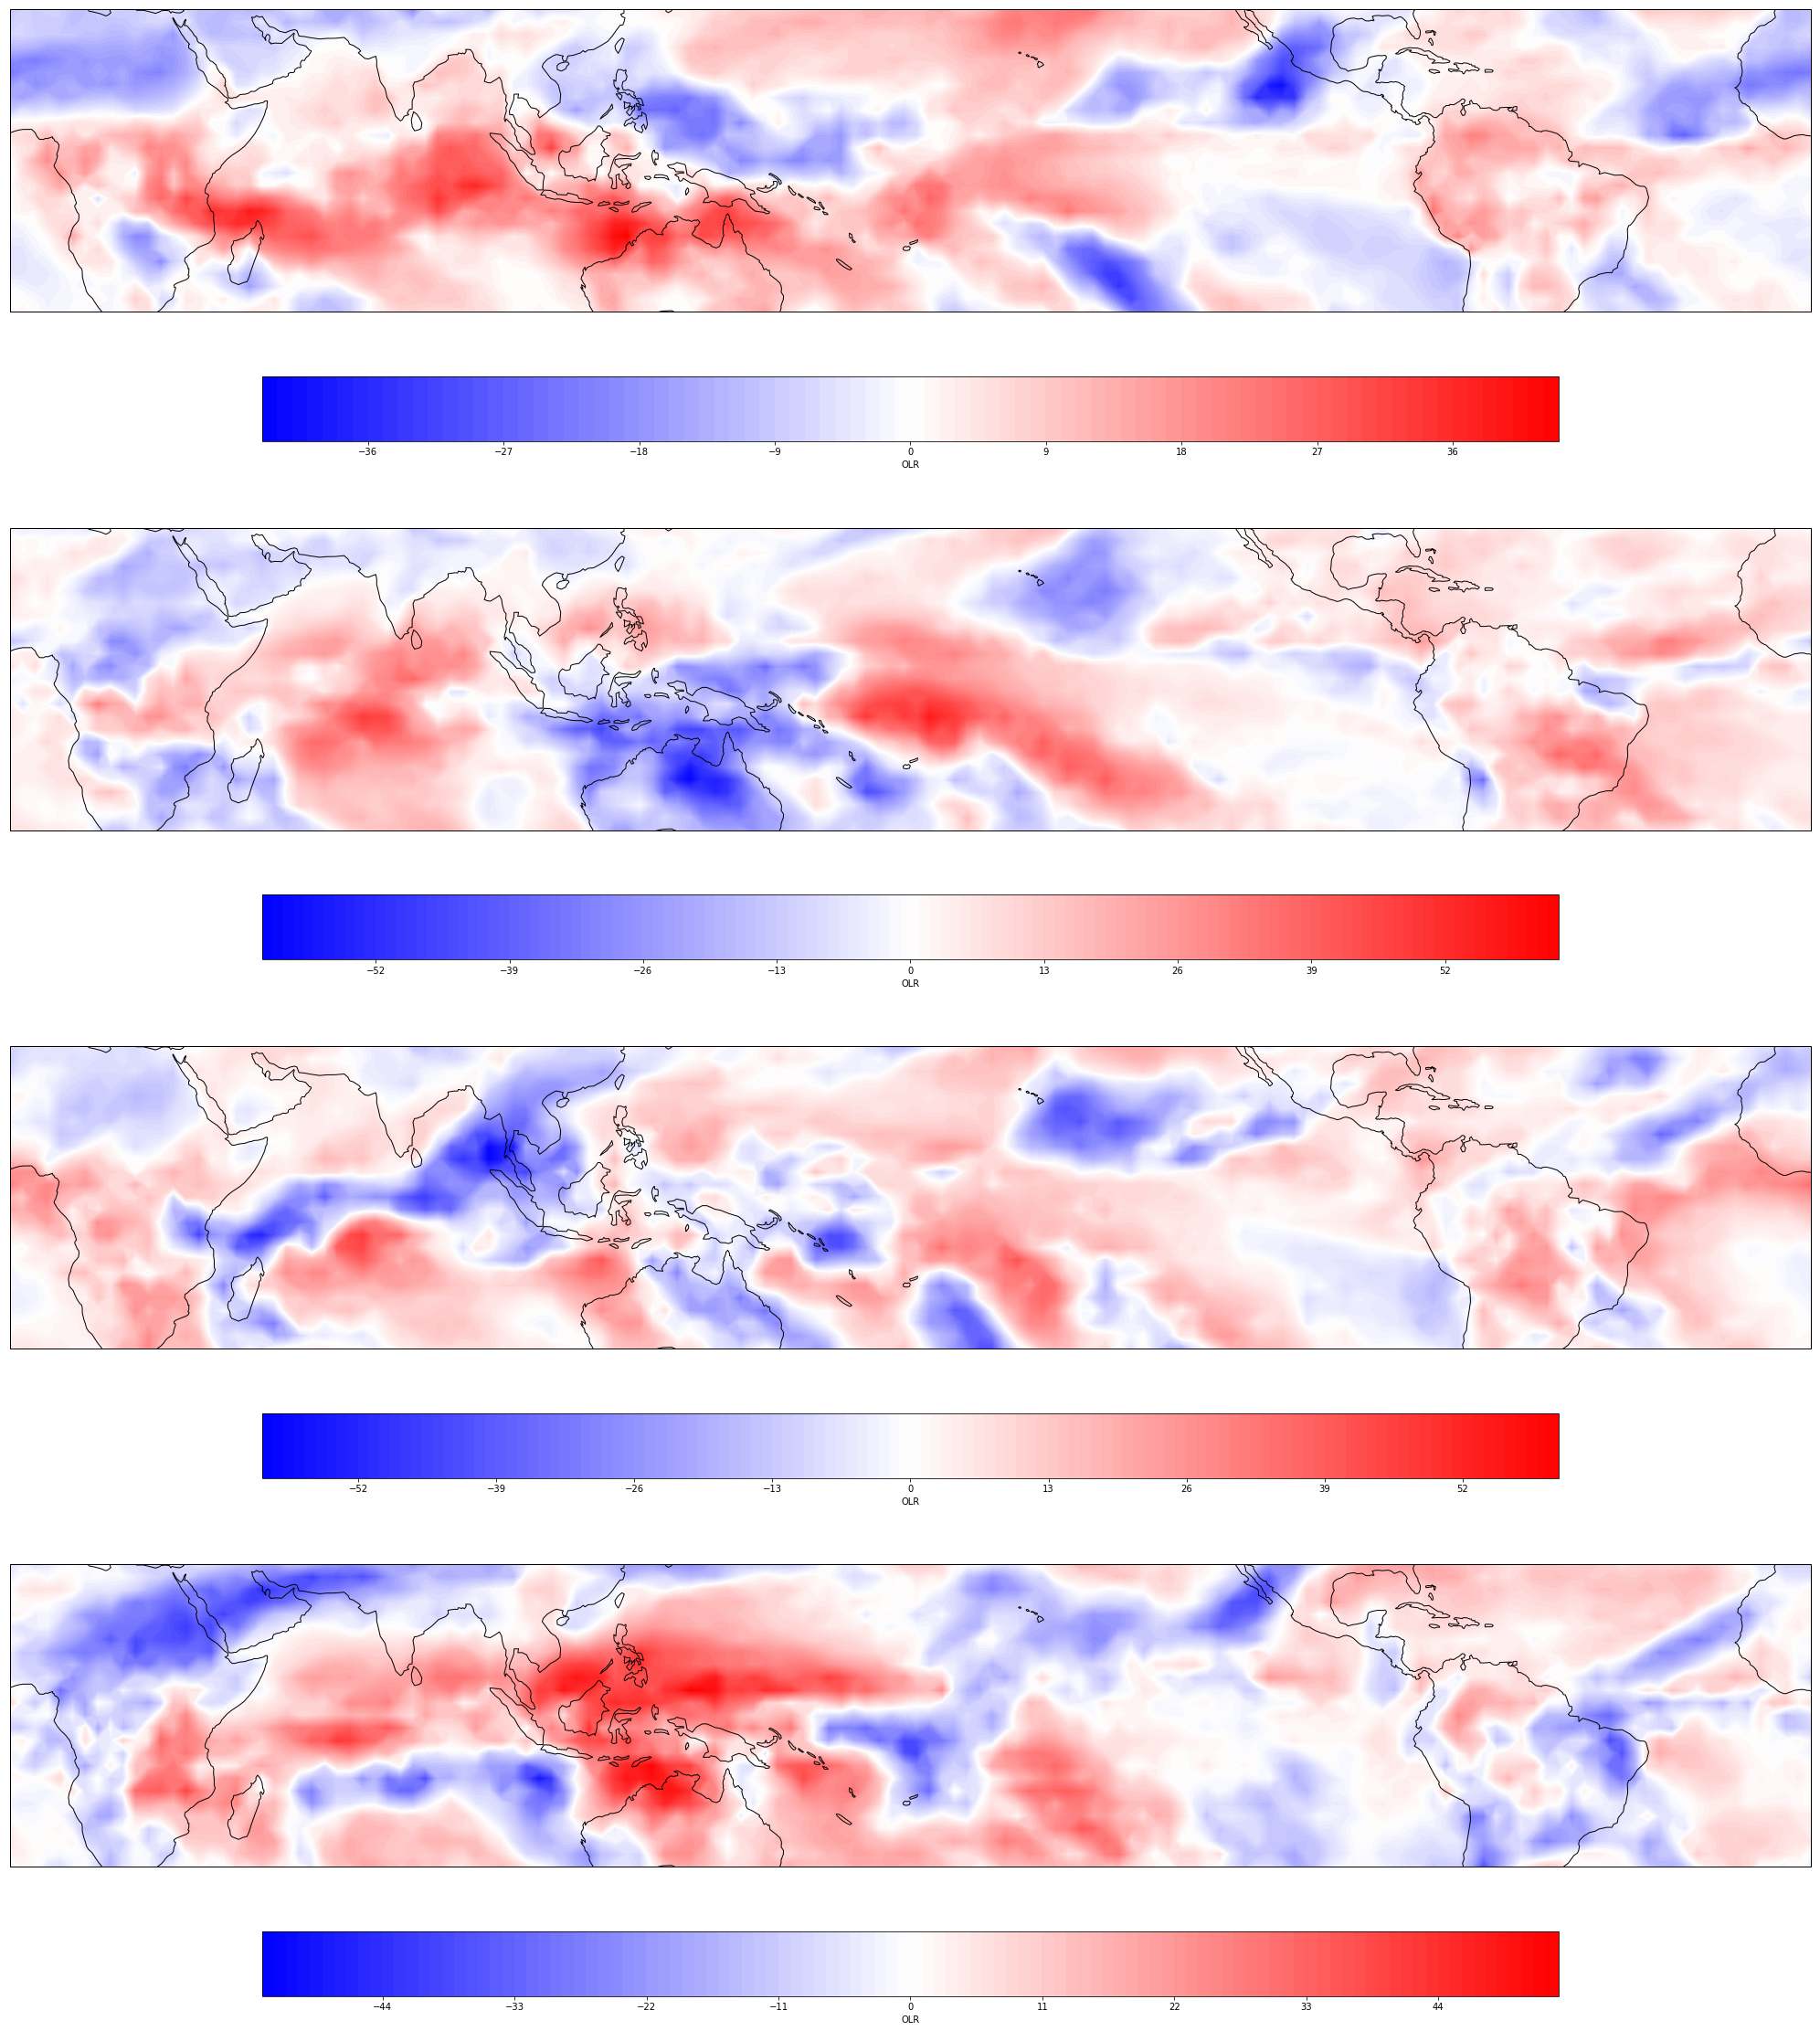

In [164]:
fig, axarr = plt.subplots(nrows=number_clusters, ncols=1, figsize=(40, number_clusters*10), subplot_kw={'projection': ccrs.LambertCylindrical(central_longitude=180)})
axlist = axarr.flatten()
for i in range(number_clusters):
  mins = []
  maxes = []
  for j in all_clusters['cluster'+str(i+1)+'_composite']:
    mins.append(min(j))
    maxes.append(max(j))
  myrange = max(np.abs(min(mins)), np.abs(max(maxes)))
  levels = np.linspace(-np.ceil(myrange), np.ceil(myrange), 2*np.ceil(myrange)+1)
#   fig = plt.figure(figsize=(20*4,5*4))
  cs=axlist[i].contourf(lon, lat, all_clusters['cluster'+str(i+1)+'_composite'][:, :],levels,
                transform=ccrs.LambertCylindrical(),
                cmap='bwr')
  axlist[i].coastlines()
#   ax.set_extent([-90, 40, 20, 80]) # longitude latitude extent
  cbar = fig.colorbar(cs, ax=axlist[i], orientation='horizontal') # color map
  cbar.set_label('OLR')
#   axlist[i].colorbar(cs, orientation='vertical') # color map
plt.savefig('mjo_try'+str(number_clusters)+'_clusters.png')
plt.show()
